In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
from tqdm import tqdm
import warnings
import time

In [2]:
warnings.filterwarnings("ignore")
plt.rcParams['animation.embed_limit'] = 2**128

start_time e end_time serviranno alla fine per il tempo di computazione

In [3]:
start_time = time.time()

In [4]:
end_time = time.time()

print(f'time total = {end_time - start_time}s')

time total = 0.006552457809448242s


Function computing global efficiency of the entire graph

In [5]:
def centrality_analysis(graph,color_map='RdBu'):
    fig, axs = plt.subplots(2, 2, figsize=(13,13))

    # compute degree centrality
    degree_centrality = nx.degree_centrality(graph)

    # compute edge betweness centrality
    edge_betweenness_centrality = nx.edge_betweenness_centrality(graph)

    # compute betweness centrality
    betweenness_centrality = nx.betweenness_centrality(graph)

    # compute closeness centrality
    closeness_centrality = nx.closeness_centrality(graph)

    #normalized degree centrality values
    dc_values = np.array([degree_centrality[node] for node in graph.nodes])
    norm_dc_values = (dc_values - min(dc_values)) / (max(dc_values) - min(dc_values))

    #normalized edge betweenness centrality values
    ebc_values = np.array([edge_betweenness_centrality[edge] for edge in graph.edges])
    norm_ebc_values = (ebc_values - min(ebc_values)) / (max(ebc_values) - min(ebc_values))

    #normalized betweenness centrality values
    bc_values = np.array([betweenness_centrality[node] for node in graph.nodes])
    norm_bc_values = (bc_values - min(bc_values)) / (max(bc_values) - min(bc_values))

    #normalized closeness centrality values
    c_values = np.array([closeness_centrality[node] for node in graph.nodes])
    norm_c_values = (c_values - min(c_values)) / (max(c_values) - min(c_values))
    
    cmap = color_map
    values = [norm_dc_values , norm_ebc_values , norm_bc_values , norm_c_values]
    names = ['Degree centrality map','Edge Betweenness centrality map','Betweenness centrality map','Closeness centrality map']
    
    for i,values in enumerate(values):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        norm=plt.Normalize(vmin=values.min(), vmax=values.max())
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        if i == 1:
            ox.plot_graph(
                    graph,
                    ax,
                    bgcolor='white',
                    node_size=0,
                    edge_color=plt.cm.RdBu(values),  
                    edge_linewidth=1, 
                    show=False)
        else: 
            ox.plot_graph(graph, ax,
                        node_color=plt.cm.RdBu(values), 
                        node_size=15, 
                        edge_linewidth=0.5, 
                        bgcolor = 'white', 
                        show=False)

        cb = fig.colorbar(sm, ax=ax, label = 'Degree centrality')
        plt.axis('on')
        ax.set_title(names[i])

    plt.show()

In [6]:
def global_efficiency(graph):
    nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)
    efficiency = 0
    efficiency_euclid = 0
    N = len(graph.nodes)
    for i in range(N):
        for j in range(N):
            if i!=j:
                if graph.has_edge(i,j):
                    d_ij = nx.shortest_path_length(G, i, j, weight='length')
                    efficiency += 1 / d_ij
                    #euclid_distance = (2*np.pi*6371000*ox.distance.euclidean(nodes['lat'][i],nodes['lon'][i],nodes['lat'][j],nodes['lon'][j]))/360
                    #efficiency_euclid += 1 / euclid_distance
                    global_efficiency = efficiency/(N*(N-1))
    return global_efficiency

Function setting velocity limit in a given number of streets

In [7]:
def set_max_speed(graph,street_names, max_speed : int):
    '''street_names : array of strings with streets names
        max_speed : in Km/h
    '''
    for _,_,data in graph.edges(data=True):
        if 'name' in data:
            if data['name'] in street_names:
                data['maxspeed'] = max_speed
                #set automatically the new travelling time
                data['travelling_time'] = data['length']*3.6 / float(data['maxspeed'])

Function setting velocity limit in every street

In [8]:
def set_max_speed_all(graph,max_speed):
    '''max_speed : in Km/h'''
    for _,_,data in graph.edges(data=True):
        data['maxspeed'] = max_speed

        #set automatically the new travelling time
        data['travelling_time'] = data['length']*3.6 / float(data['maxspeed'])

Function removing streets

In [9]:
def remove_edges(graph,street_names):
    edges_to_be_removed = []
    for u,v,data in graph.edges(data=True):
        if 'name' in data and data['name'] in street_names:
            edges_to_be_removed.append([u,v])
    
    for u,v in edges_to_be_removed:
        if u in graph.nodes:
            graph.remove_node(u)
        if v in graph.nodes:
            graph.remove_node(v)

Function fixing bugs of Osmnx edges data and setting travelling times (sometimes maxspeed of edges is a string or a list of strings)

<div style="color: red; font-weight:bold"> 
Needs to be runned before others when initializing the graph!
</div> 

In [10]:
def clean_graph_data(graph):
    #function fixing bugs in graph.edges and setting travelling time, NEEDS TO BE RUNNED AS FIRST!!!!!
    for _,_,data in graph.edges(data=True):
        data['passage'] = 0
        data['accident'] = 0
        if 'maxspeed' not in data:
            data['maxspeed'] = 30.0
        if type(data['maxspeed']) == list:
            data['maxspeed'] = data['maxspeed'][0]
        if data['maxspeed'] == 'signals' or data['maxspeed'] == 'IT:urban':
            data['maxspeed'] = 30.0
        if 'name' in data and type(data['name']) == list:
            data['name'] = data['name'][0]

        data['maxspeed'] = float(data['maxspeed'])
        data['travelling_time'] = data['length']*3.6 / float(data['maxspeed'])

    for _,data in graph.nodes(data=True):
        data['accident'] = 0

Function showing traffic flow and accidents

In [11]:
def show_traffic_and_accident(graph,edges_passage,accident_positions):
    nodes,edges = ox.graph_to_gdfs(graph,nodes=True,edges=True)

    for edge in edges_passage:
        edges.loc[edge,'passage'][0] += 1

    for u,data in graph.nodes(data=True):
        if u in accident_positions:
            u = int(u)
            #data['accident'] += 1
            nodes.loc[u,'accident'] += 1

    graph = ox.graph_from_gdfs(nodes,edges)
    # Get edge passages
    edge_values = [data['passage'] for u, v, key, data in graph.edges(keys=True, data=True)]

    # Define a colormap
    cmap = plt.cm.RdBu 

    # Normalize edge lengths
    norm = plt.Normalize(min(edge_values), max(edge_values))

    # Map edge lengths to colors
    colors = [cmap(norm(value)) for value in edge_values]

    #Plot the network with colored edges
    fig , ax = ox.plot_graph(graph, edge_color=colors, node_size=0, bgcolor='black', edge_linewidth=0.5,show=False)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax,label='Edge Passage')
    plt.title('Roads more populated')
    plt.show()

    #dc_values = np.array([degree_centrality[node] for node in G.nodes])
    acc_values = np.array([data['accident'] for _,data in graph.nodes(data=True)])
    # normalize 
    norm_acc_values = (acc_values - min(acc_values)) / (max(acc_values) - min(acc_values))

    # Plot the graph with a heatmap based on degree centrality
    cmap = 'RdBu'
    norm=plt.Normalize(vmin=norm_acc_values.min(), vmax=norm_acc_values.max())
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])


    fig,ax=ox.plot_graph(graph,
                            node_color=plt.cm.RdBu(norm_acc_values), 
                            node_size=5, 
                            edge_linewidth=0.5, 
                            bgcolor = 'white', 
                            show=False)

    cb = fig.colorbar(sm, ax=ax, label = 'Accidents')
    plt.axis('on')
    plt.title('Accidents')
    plt.show()

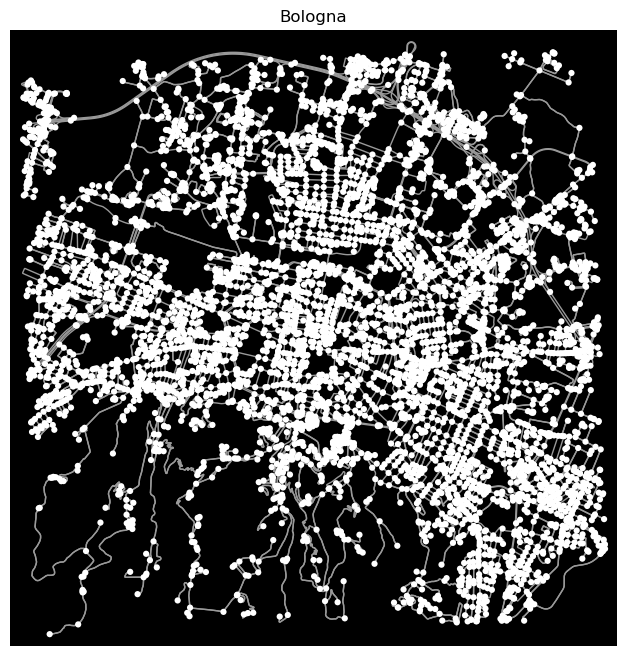

In [103]:
Bologna = (44.495555, 11.3428)
Bologna_radius = 4000
# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(Bologna, dist=Bologna_radius, dist_type='bbox', network_type='drive_service', simplify = True)
G = ox.project_graph(G)
osmids = list(G.nodes)
G = nx.relabel.convert_node_labels_to_integers(G)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G.nodes, osmids)}
nx.set_node_attributes(G, osmid_values, "osmid")


fig, ax = ox.plot.plot_graph(G, bgcolor='black',node_size=20, node_color='white', show=False)
plt.axis('on')
plt.title('Bologna')
plt.show()

#inizializing some useful graph attributes
clean_graph_data(G)

In [13]:
#connectivity analysis
n_edges = G.number_of_edges()
n_nodes = G.number_of_nodes()

#meshedness coefficient
alpha = (n_edges - n_nodes + 1) / (2 * n_nodes - 5)

#connectivity
beta = n_edges/n_nodes

# gammaindex is a measure of the relation between the real number of edges and the number of all possible edges in a network
gamma = n_edges/(3*(n_nodes-2))

#characteristic path length
#l_geo = nx.average_shortest_path_length(G)

#print results
print('# Edges: ', n_edges)
print('# Nodes: ', n_nodes)
print("meshedness coefficient:", alpha)
print("beta connectivity:", beta)
print("gamma index", gamma)
#print("characteristic path length:", l_geo)


# Edges:  8576
# Nodes:  4416
meshedness coefficient: 0.47139458479664664
beta connectivity: 1.9420289855072463
gamma index 0.6476363087146957


In [ ]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

fig = plt.figure("Degree of a random graph", figsize=(15, 15))

axgrid = fig.add_gridspec(5, 4)



ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

In [ ]:
centrality_analysis(G)

In [ ]:
#computing Global Efficiency
G1 = global_efficiency(G)

#computing Information Centrality
G.remove_edge(4,7) #remove some edges wiht for loops
G2 = global_efficiency(G) #ma perchè scriviamo in inglese?
print(G1,G2, G1-G2, (G1-G2)/G1) #scemo chi legge
#G.edges #scemo chi l'edges

# CLASSE CARS

In [13]:
class Cars():
    def __init__(self,n_cars):
        self.journey = np.zeros((n_cars,2))
        self.positions = np.zeros((n_cars,2))
        self.velocities = np.zeros((n_cars,2))
        self.accel = np.zeros((n_cars,2))
        self.max_speed = np.zeros(n_cars)
        self.turn_range = np.zeros(n_cars)
        self.position_along_path = np.zeros(n_cars,dtype=int)
        self.n_cars = n_cars
        self.speed_up = 1
        self.accidents = 0


    def get_positions(self):
        return self.positions
    
    def get_velocities(self):
        return self.velocities
    
    def get_n_cars(self):
        return self.n_cars
    
    def number_of_accidents(self):
        return self.accidents
    
    def set_acceleration_zero(self):
        for i in range(self.n_cars):
            self.accel[i] = (0,0)
    
    def get_velocity_angle(self,car_i):
        vx = self.velocities[car_i][0]
        v = np.linalg.norm(self.velocities[car_i])
        arccos = np.arccos(vx/v)
        if arccos > 0:
            if self.velocities[car_i][1] > 0:
                angle = arccos*180/np.pi
            elif self.velocities[car_i][1] < 0:
                angle = -arccos*180/np.pi
            else:
                angle = 0
        
        if arccos < 0:
            if self.velocities[car_i][1] > 0:
                angle = arccos*180/np.pi
            elif self.velocities[car_i][1] < 0:
                angle = -arccos*180/np.pi
            else:
                angle = 180

        if arccos == 0:
            if self.velocities[car_i][1] > 0:
                angle = 90
            elif self.velocities[car_i][1] < 0:
                angle = 270

        return angle
             
    def get_angle(self,vector):
        x = vector[0]
        y=vector[1]
        v = np.linalg.norm(vector)
        arccos = np.arccos(x/v)
        if arccos > 0:
            if y > 0:
                angle = arccos*180/np.pi
            elif y < 0:
                angle = -arccos*180/np.pi
            else:
                angle = 0
        
        if arccos < 0:
            if y > 0:
                angle = arccos*180/np.pi
            elif y < 0:
                angle = -arccos*180/np.pi
            else:
                angle = 180

        if arccos == 0:
            if y > 0:
                angle = 90
            elif y < 0:
                angle = 270

        return angle

    def another_car_is_near(self,car_i,size,radius):
        for n in range(self.n_cars):
            diff_position = self.positions[n] - self.positions[car_i]
            dist = np.linalg.norm(diff_position)
            v_i = np.linalg.norm(self.velocities[car_i])
            v_n = np.linalg.norm(self.velocities[n])
            
            if n!=car_i and dist <= v_i*2*2*radius/(size*self.speed_up): #5 è per vedere se funziona
                diff_angles = np.abs(self.get_velocity_angle(n) - self.get_velocity_angle(car_i))
                diff_velocities = v_i - v_n
                angle_positions = np.abs(self.get_angle(diff_position)-self.get_velocity_angle(car_i))

                if diff_angles <= 160 and diff_angles >= 20:
                    return True , dist
                
                if diff_angles <= 20 and diff_velocities > 0 and angle_positions <= 20:
                    return True , dist
                
                else:
                    return False , dist
            else: 
                return False , dist


    def accident_probability_distribution(self,v,size,radius):
        dv = v*3.6*2*radius/(size*self.speed_up)
        p = 0.01/(0.01+np.exp(-dv*2/100))

        return p/10
    

    def accident(self,car_i,size,radius):
        for n in range(self.n_cars):
            dist = np.linalg.norm(self.positions[car_i] - self.positions[n])
            v_i = np.linalg.norm(self.velocities[car_i])
            a_i = np.linalg.norm(self.accel[car_i])
            diff_velocities = np.linalg.norm(self.velocities[car_i] - self.velocities[n])

            if n!=car_i and dist <= v_i*2*2*radius/(size*self.speed_up) and a_i >= 4*size*self.speed_up/(2*radius): #and a_i >= v_i A THRESHOLD CAMBIALO
                diff_angles = np.abs(self.get_velocity_angle(n) - self.get_velocity_angle(car_i))
                if diff_angles <= 180 and diff_angles >= 20:
                    r = np.random.uniform(0,1)
                    if r <= self.accident_probability_distribution(diff_velocities,size,radius):
                        return True
                    else:
                        return False
                else: 
                    return False
            else: 
                return False

    def start_another_journey(self,car_i,graph,size,radius,edge_passage,nodes,edges,dt):
        start = random.randint(min(graph.nodes) , max(graph.nodes))

        while True:
                target = random.randint(min(graph.nodes) , max(graph.nodes))
                if target != start:
                    break

        road = ox.shortest_path(graph,start,target,weight='travelling_time')

        if road is None:
            while True:
                if road is None:
                    start = random.randint(min(graph.nodes) , max(graph.nodes))
                    while True:
                        target = random.randint(min(graph.nodes) , max(graph.nodes))
                        if target != start:
                            break
                    road = road = ox.shortest_path(graph,start,target,weight='travelling_time')
                else:
                    break
            
        for l in range(len(road)-1):
            #edges.loc[(road[l],road[l+1]),'passage'][0] += 1
            edge_passage.append((road[l],road[l+1]))
        
        graph = ox.graph_from_gdfs(nodes,edges) #CONTROLLA E CORREGGI QUESTA PARTE MOLTO IMPORTANTE
            
        self.journey[car_i] = (start , target)

        node_direction = np.array([nodes['x'][road[1]] - nodes['x'][road[0]] , nodes['y'][road[1]] - nodes['y'][road[0]]])
        node_direction /= np.linalg.norm(node_direction)

        self.positions[car_i] = (nodes['x'][start] , nodes['y'][start])

        self.max_speed[car_i] = float(edges['maxspeed'][road[0]][road[1]][0])*self.speed_up*size/(3.6*2*radius)  #speed limit in m/s
        v = random.uniform(self.max_speed[car_i]/4 , self.max_speed[car_i])
        self.velocities[car_i] = v*node_direction

        self.turn_range[car_i] = v*dt
        


    def set_initial_condition(self,graph,size,radius,speed_up,dt,edge_passage,nodes,edges):
        #self.max_speed = max_speed
        self.speed_up = speed_up

        for i in range(self.n_cars):
            start = random.randint(min(graph.nodes) , max(graph.nodes))

            while True:
                target = random.randint(min(graph.nodes) , max(graph.nodes))
                if target != start:
                    break

            road = ox.shortest_path(graph,start,target,weight='travelling_time')

            if road is None:
                while True:
                    if road is None:
                        start = random.randint(min(graph.nodes) , max(graph.nodes))
                        while True:
                            target = random.randint(min(graph.nodes) , max(graph.nodes))
                            if target != start:
                                break
                        road = road = ox.shortest_path(graph,start,target,weight='travelling_time')
                    else:
                        break
            
            for l in range(len(road)-1):
                #edges.loc[(road[l],road[l+1]),'passage'][0] += 1
                edge_passage.append((road[l],road[l+1]))
                
            graph = ox.graph_from_gdfs(nodes,edges) #CONTROLLA E CORREGGI QUESTA PARTE MOLTO IMPORTANTE
            
            self.journey[i] = (start , target)

            node_direction = np.array([nodes['x'][road[1]] - nodes['x'][road[0]] , nodes['y'][road[1]] - nodes['y'][road[0]]])
            node_direction /= np.linalg.norm(node_direction)

            self.positions[i] = (nodes['x'][start] , nodes['y'][start])

            self.max_speed[i] = float(edges['maxspeed'][road[0]][road[1]][0])*speed_up*size/(3.6*2*radius)  #speed limit in m/s
            v = random.uniform(self.max_speed[i]/4 , self.max_speed[i])
            self.velocities[i] = v*node_direction

            self.turn_range[i] = v*dt



    def update(self,graph,size,radius,dt,nodes,edges,edge_passage,accident_position):

        #nodes, _ = ox.graph_to_gdfs(graph, nodes=True, edges=True)
        #nodes['x'] = ((nodes['x'] - min(nodes['x']))/(max(nodes['x'])-min(nodes['x'])))*size
        #nodes['y'] = ((nodes['y']-min(nodes['y']))/(max(nodes['y']) - min(nodes['y'])))*size

        for i in range(self.n_cars):
            road = ox.shortest_path(graph,self.journey[i][0],self.journey[i][1],weight='travelling_time')
            v_abs = np.linalg.norm(self.velocities[i])
            L = len(road)
        
            #start another journey when target reached
            if np.linalg.norm(self.positions[i]- np.array([nodes['x'][road[L-1]] , nodes['y'][road[L-1]]])) <= self.turn_range[i]:
                self.start_another_journey(i,graph,size,radius,edge_passage,nodes,edges,dt)
                self.position_along_path[i] = 0
                #self.velocities[i] = (0.0001,0.0001)
                #self.positions[i] = (-1,-1)
                continue
            

            #ACCELERAZIONI PER I NODI, GUARDA BENE E CAMBIA COSE 
            if np.linalg.norm(self.positions[i]-np.array([(nodes['x'][road[self.position_along_path[i]+1]]) , nodes['y'][road[self.position_along_path[i]+1]]])) <= v_abs*2*radius/(size*self.speed_up):
                self.accel[i] = -self.velocities[i]/15
                self.velocities[i] += self.accel[i]*dt
            elif np.linalg.norm(self.positions[i]-np.array([(nodes['x'][road[self.position_along_path[i]+1]]) , nodes['y'][road[self.position_along_path[i]+1]]])) >= v_abs*2*radius/(size*self.speed_up):
                self.accel[i] = self.velocities[i]/5
                self.velocities[i] += self.accel[i]*dt

            #DECELERAZIONI SE VEDE MACCHINE, ATTENZIONE A QUEL +=
            if self.another_car_is_near(i,size,radius)[0]:
                self.accel[i] += -self.velocities[i]/self.another_car_is_near(i,size,radius)[1]
                self.velocities[i] += self.accel[i]*dt
            else: 
                self.accel[i] += self.velocities[i]/5
                self.velocities[i] += self.accel[i]*dt

            #ACCELERAZIONE SE NON VEDE MACCHINE, ATTENZIONE A QUEL +=
            if self.another_car_is_near(i,size,radius)[0] == False and v_abs <= 0.1*self.max_speed[i]:
                self.accel[i] += self.velocities[i]/4
                self.velocities[i] += self.accel[i]*dt
                    
            #ACCIDENTS
            if self.accident(i,size,radius):
                self.accidents += 1   
                self.velocities[i] = (0.0,0.0)
                #accident_position.append(self.positions[i])
                d_1 = np.linalg.norm(self.positions[i]-np.array([(nodes['x'][road[self.position_along_path[i]]]) , nodes['y'][road[self.position_along_path[i]]]]))
                d_2 = np.linalg.norm(self.positions[i]-np.array([(nodes['x'][road[self.position_along_path[i]+1]]) , nodes['y'][road[self.position_along_path[i]+1]]]))
                if d_1 < d_2:
                    accident_position.append(road[self.position_along_path[i]])
                else: 
                    accident_position.append(road[self.position_along_path[i]+1])

            #change direction if an intermediate node is near
            if np.linalg.norm(self.positions[i]-np.array([(nodes['x'][road[self.position_along_path[i]+1]]) , nodes['y'][road[self.position_along_path[i]+1]]])) <= self.turn_range[i]:
                self.position_along_path[i] += 1
        
                v_abs = np.linalg.norm(self.velocities[i])
                self.max_speed[i] = float(edges['maxspeed'][road[self.position_along_path[i]]][road[self.position_along_path[i]+1]][0])*self.speed_up*size/(3.6*2*radius)

                node_direction = np.array([nodes['x'][road[self.position_along_path[i]+1]]- self.positions[i][0] , nodes['y'][road[self.position_along_path[i]+1]] - self.positions[i][1]])
                node_direction /= np.linalg.norm(node_direction)

                self.velocities[i] = v_abs*node_direction
            
            #if exceed limit, put velocity back to speed limit
            if v_abs >= self.max_speed[i]:
                self.accel[i] += -(v_abs - self.max_speed[i])*self.velocities[i]/v_abs
                self.velocities[i] += self.accel[i]*dt
            #update positions
            self.positions[i] += self.velocities[i]*dt + self.accel[i]*dt*dt/2
            

# Funzione che usa la classe CARS

In [14]:
def simulation_cars(graph, n_cars, radius, speed_up, size = 100, scale = 0.6, dt = 0.05, n_time_steps = 300, map = True, animate = True):
    
    ''' speed_up = speed_up factor making simulation faster than reality
    
        size : refers to maximum value of animation image boundaries. Needs to be converted in meters using Bologna diameter

        scale : refers to arrows dimensions within the animation
       
        turn range : range with which the car sees a new node and turn its velocity. Take it around  max_speed*dt
       '''
    cars = Cars(n_cars)
    edges_passage = []
    accident_positions = []
    nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)
    nodes['x'] = ((nodes['x'] - min(nodes['x']))/(max(nodes['x'])-min(nodes['x'])))*size
    nodes['y'] = ((nodes['y']-min(nodes['y']))/(max(nodes['y']) - min(nodes['y'])))*size
    
    cars.set_initial_condition(graph,size,radius,speed_up,dt,edges_passage,nodes,edges)
    
    n_cars = cars.get_n_cars()
    c_positions = np.zeros((n_time_steps, n_cars, 2))
    c_velocities = np.zeros((n_time_steps, n_cars, 2))

    #for loop computing time steps for animation
    for n in tqdm(range(n_time_steps)):
        c_positions[n] = cars.get_positions()
        c_velocities[n] = cars.get_velocities()
        
        cars.set_acceleration_zero()

        cars.update(graph,size,radius,dt,nodes,edges,edges_passage,accident_positions)
        

    if animate:
        fig, ax = plt.subplots(figsize=(7,7))

        if map:
            for N in range(len(graph.nodes)):
                circle = plt.Circle((nodes['x'][N] , nodes['y'][N]) , size/900, color = 'grey')
                ax.add_patch(circle)
        
        
        velocities_magnitudes = np.linalg.norm(c_velocities[0], axis=1)
        velocities_normalized = c_velocities[0] / np.vstack([velocities_magnitudes, velocities_magnitudes]).T 
        #velocities_normalized = c_velocities[0] * 0.5
        scat = ax.quiver(c_positions[0][:,0], 
                        c_positions[0][:,1],
                        velocities_normalized[:,0],
                        velocities_normalized[:,1], color = 'red')
        
        
        ax.set_xlim(0,size)
        ax.set_ylim(0,size)

        #update function useful for animation
        def update(frame):
            scat.set_offsets(c_positions[frame])

            velocities_magnitudes = np.linalg.norm(c_velocities[frame], axis=1)
            velocities_normalized = c_velocities[frame]/ np.vstack([velocities_magnitudes, velocities_magnitudes]).T 
            #velocities_normalized *= scale
            scat.set_UVC(velocities_normalized[:,0]*scale, 
                        velocities_normalized[:,1]*scale)

            return scat,

        ani = FuncAnimation(fig, update, frames=n_time_steps, blit=True)
        print("Animation finished. Video processing ...\n")
        display(HTML(ani.to_jshtml()))
    
    cars_velocities = np.zeros((np.shape(c_velocities)[0],np.shape(c_velocities)[1]))
    max_velocity_per_frame = np.zeros(n_time_steps)
    mean_velocity_per_frame = np.zeros(n_time_steps)

    for i in range(np.shape(c_velocities)[0]):
        for n in range(np.shape(c_velocities)[1]):
            cars_velocities[i][n] = np.linalg.norm(c_velocities[i][n])*3.6*2*radius/(size*speed_up)
        mean_velocity_per_frame[i] = np.mean(cars_velocities[i])
        max_velocity_per_frame[i] = max(cars_velocities[i])
    mean_velocity = np.mean(mean_velocity_per_frame)
    
    print(f"Velocity respect to real life is {speed_up} faster \n")
    print(f"Number of accidents: {cars.number_of_accidents()}\n")
    print(f'Mean velocity: {mean_velocity} Km/h\n')
    #nodes, edges = ox.graph_to_gdfs(traffic_graph, nodes=True, edges=True)
    
    return cars_velocities , max_velocity_per_frame, edges_passage, accident_positions

In [178]:
cars_velocities , max_velocity_per_frame, edges_passage, accident_positions = simulation_cars(G,
                n_cars = 20,
                radius = Bologna_radius,
                speed_up = 100,
                size = 10,
                scale = 0.3,
                dt = 0.05,
                n_time_steps = 100,
                map = True, 
                animate=False)

100%|██████████| 100/100 [00:17<00:00,  5.82it/s]

Velocity respect to real life is 100 faster 

Number of accidents: 1

Mean velocity: 11.864634295022508 Km/h



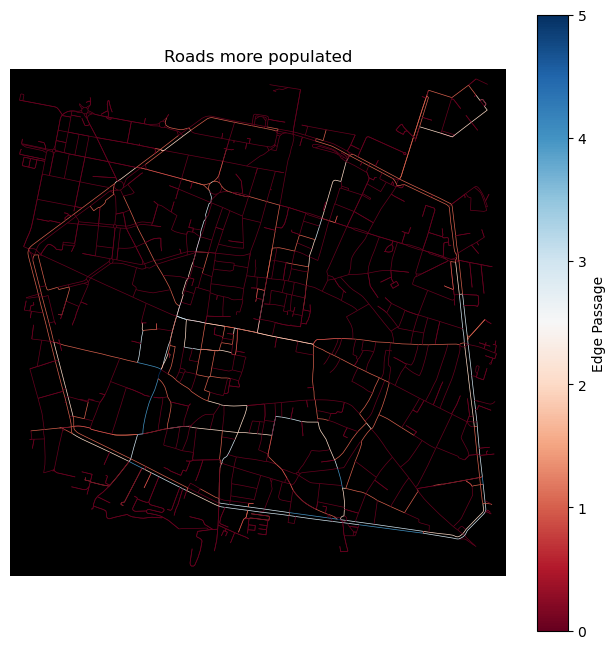

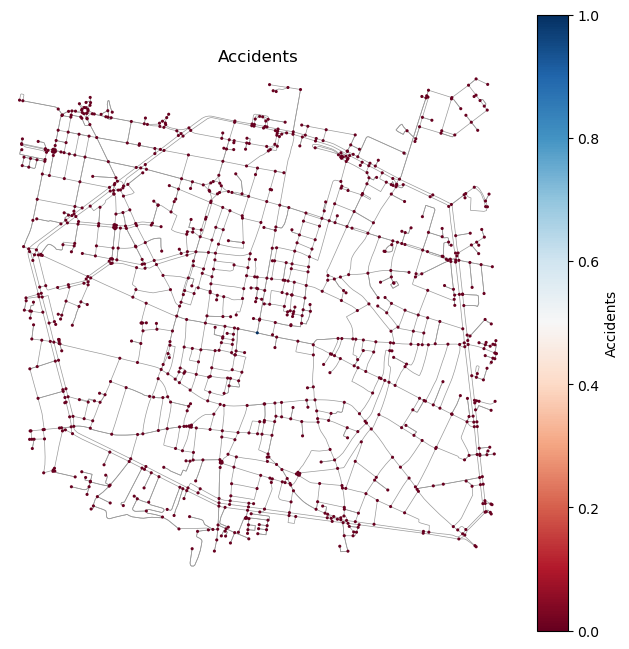

In [179]:
show_traffic_and_accident(G,edges_passage,accident_positions)

### np.concatenate servirà quando facciamo N simulazioni e vogliamo sommare gli incidenti

In [ ]:
a = np.array([[1,2],[3,4]])
b = np.array([[5,6]])

c = np.concatenate((a,b))
c

### Questo sotto ci servirà dopo

In [ ]:
# Generate some random data for histograms
#data = [np.random.randn(1000) for _ in range(10)]

# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Define the initial histogram
n_bins = int(max(max_velocity_per_frame))
hist, _ = np.histogram(cars_velocities[0], bins=n_bins)
bars = ax.bar(range(n_bins), hist)

# Update function for each frame
def update(frame):
    ax.cla()  # Clear previous plot
    hist, _ = np.histogram(cars_velocities[frame], bins=n_bins)
    ax.bar(range(n_bins), hist)
    ax.set_title(f'Frame {frame+1}')
    ax.set_xlabel('Km/h')
    ax.set_ylabel('Frequency')

# Create the animation
ani = FuncAnimation(fig, update, frames=np.shape(cars_velocities)[0])
display(HTML(ani.to_jshtml()))

plt.show()

# DATI TRAFFICO REALI

In [88]:
traffico = pd.read_excel('rilevazione-flusso-veicoli-tramite-spire-anno-2024.xlsx')

In [89]:
traffico['total'] = np.zeros(len(traffico['x']))

In [90]:
traffico

,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,stato,codimpsem,direzione,angolo,longitudine,latitudine,x,y,giorno settimana,total
0,2024-01-01,0.127 1.4 2 1,142,113,84,45,28,29,26,20,...,A,318,S,170,11.347424,44.500815,686613.347610,4.930180e+06,Lunedì,0.0
1,2024-01-01,0.127 1.5 5 1,48,56,37,30,18,22,8,7,...,A,250,N,343,11.343408,44.501173,686292.936470,4.930211e+06,Lunedì,0.0
2,2024-01-01,0.127 1.5 8 1,45,63,43,34,37,39,36,41,...,A,250,E,255,11.343170,44.501419,686273.218877,4.930237e+06,Lunedì,0.0
3,2024-01-01,0.127 1.14 4 1,13,13,13,11,2,3,6,5,...,A,92,E,264,11.339836,44.490116,686044.089674,4.928974e+06,Lunedì,0.0
4,2024-01-01,0.127 1.18 2 1,91,142,128,88,56,39,52,41,...,A,327,S,167,11.338515,44.499233,685910.076003,4.929984e+06,Lunedì,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50992,2024-02-29,4.95 4.18 4 1,25,7,4,0,2,23,65,179,...,A,187,N,335,11.361859,44.487228,687804.501582,4.928704e+06,Giovedì,0.0
50993,2024-02-29,4.95 4.94 6 1,50,16,7,4,9,23,45,207,...,A,187,E,242,11.362150,44.486843,687828.875591,4.928662e+06,Giovedì,0.0
50994,2024-02-29,4.98 0.127 6 1,54,16,14,10,24,48,219,748,...,A,176,N,352,11.385481,44.469397,689740.640032,4.926778e+06,Giovedì,0.0
50995,2024-02-29,4.98 0.127 8 1,3,2,1,0,2,1,4,29,...,A,176,E,257,11.385614,44.469066,689752.318933,4.926741e+06,Giovedì,0.0


In [24]:
for dati in traffico:
    if dati == '05:00-06:00':
        print(dati)
a = 11
b = 13
a_s = str(11)
b_s = str(13)
d = b-a
for _ in range(d):
    print(a_s+':00-'+str(int(a_s) + 1)+':00')
    a += 1
    a_s = str(a)


#traffico[a+':00-'+str(int(a) + 1)+':00']
#traffico['11:00-12:00']


05:00-06:00
11:00-12:00
12:00-13:00


In [ ]:
filtered_data = traffico[traffico['giorno settimana'].isin(['Mercoledì'])]
for lat,long in zip(filtered_data['latitudine'],filtered_data['longitudine']):
    print(long)

# CAMBIA IL NUMERO DI 'PASSAGE'

In [110]:
def show_traffic_data(graph,traffic_data,days,hours = [0,24]): 
    traffic_edges = []
    passage_values = []
    
    #data = traffic_data['latitudine'],traffic_data['longitudine'],traffic_data['giorno settimana']

    # Filter traffic data based on 'giorno settimana'
    filtered_data = traffic_data[traffic_data['giorno settimana'].isin(days)]
    min_hour = hours[0]
    max_hour = hours[1]
    diff_hours = max_hour - min_hour
    min_hour_str = str(min_hour)
    max_hour_str = str(max_hour)

    for _ in range(d):
        filtered_data['total'] += filtered_data[min_hour_str+':00-'+str(int(min_hour_str) + 1)+':00']
        min_hour += 1
        min_hour_str = str(min_hour)

    # Use `nearest_edges` function on filtered data
    #traffic_edges = filtered_data.apply(lambda row: ox.nearest_edges(graph, row['latitudine'], row['longitudine'])[:2], axis=1)

    '''with tqdm(total=len(filtered_data)) as pbar:
        # Use apply function to apply nearest_edges function on each row
        traffic_edges = filtered_data.apply(lambda row: ox.nearest_edges(graph, row['latitudine'], row['longitudine'])[:2], axis=1)
        pbar.update(len(filtered_data))'''
    # Calculate the total number of rows in the DataFrame
    #total_rows = len(filtered_data)

    traffic_edges = ox.nearest_edges(graph,filtered_data['x'],filtered_data['y'])

    for a in filtered_data['total']:
        passage_values.append(a)

    
    #with tqdm(total=total_rows) as pbar:
        #for lat, long in zip(filtered_data['latitudine'], filtered_data['longitudine']):
            #traffic_edges.append(ox.nearest_edges(graph,lat,long)[:2])

            #pbar.update(1)

    #for lat,long in tqdm(zip(filtered_data['latitudine'],filtered_data['longitudine'])):
        #if filtered_data['giorno settimana'][i] in days:
        #traffic_edges.append(ox.nearest_edges(graph,data[0][i],data[1][i])[:2])
        #traffic_edges.append(ox.nearest_edges(graph,lat,long)[:2])

    nodes,edges = ox.graph_to_gdfs(graph,nodes=True,edges=True)

    for i in range(len(traffic_edges)):
        edges.loc[(traffic_edges[i][0],traffic_edges[i][1]),'passage'][0] += passage_values[i]

    #for edge in traffic_edges:
        #edges.loc[(edge[0],edge[1]),'passage'][0] += edges[2]

    graph = ox.graph_from_gdfs(nodes,edges)

    #Get edge passages
    edge_values = np.array([data['passage'] for u, v, key, data in graph.edges(keys=True, data=True)])
    norm_edge_values = (edge_values - min(edge_values))/(max(edge_values - min(edge_values)))

    # Define a colormap
    cmap = plt.cm.RdBu 

    # Normalize edge lengths
    norm = plt.Normalize(min(norm_edge_values), max(norm_edge_values))

    # Map edge lengths to colors
    colors = [cmap(norm(value)) for value in edge_values]

    #Plot the network with colored edges
    fig , ax = ox.plot_graph(graph, edge_color=plt.cm.RdBu(edge_values), node_size=0, bgcolor='black', edge_linewidth=0.5,show=False)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax,label='Edge Passage')
    plt.title('Traffic data')
    plt.show()
    

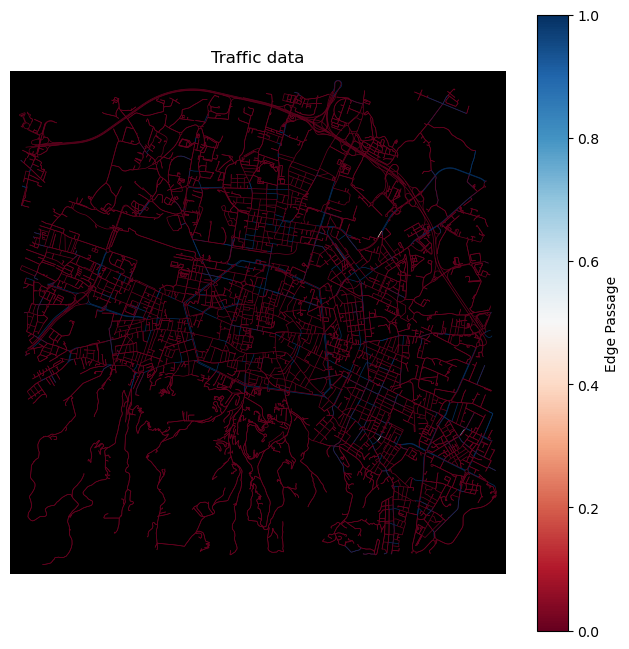

In [111]:
days = ['Mercoledì']
show_traffic_data(G,traffico,days,[11,13])

In [55]:
incidenti = pd.read_excel('Incidenti.xlsx')

In [16]:
incidenti

,ID,DATA,ORA,GIORNO,DINAMICA,X,Y
0,4049148,2010-01-01,9,MONDAY,Scontro laterale,685281.272,4930115.619
1,4057070,2010-01-01,17,TUESDAY,Scontro frontale,685246.852,4930507.099
2,4057088,2010-01-01,12,WEDNESDAY,Tamponamento,685224.147,4929355.007
3,4060978,2010-01-01,9,MONDAY,Scontro frontale,685187.296,4929460.483
4,4061328,2010-01-01,9,MONDAY,Scontro frontale,685205.027,4930515.345
...,...,...,...,...,...,...,...
5816,4229981,2022-01-01,19,WEDNESDAY,Scontro laterale,687217.282,4928649.892
5817,4231848,2022-01-01,17,TUESDAY,Infortunio per caduta da veicolo,687102.547,4928267.506
5818,4233852,2022-01-01,16,FRIDAY,Tamponamento,687205.830,4928660.679
5819,4243990,2022-01-01,9,WEDNESDAY,Scontro frontale,687216.551,4928647.648


In [17]:
print(incidenti['DATA'][0].year,type(incidenti['DATA'][0].year))
print(type(incidenti['GIORNO'][0]))
print(incidenti['ORA'][0],type(incidenti['ORA'][0]))
print(type(incidenti['X'][1].astype(float)))
len(incidenti['X'])
a = [2010,2011]
incidenti['DATA'][0].year in a

2010 <class 'int'>
<class 'str'>
9 <class 'numpy.int64'>
<class 'numpy.float64'>


True

In [65]:
def show_accident_data(graph,accident_data,years,hours=[0,24]):
    nodes,edges = ox.graph_to_gdfs(graph,nodes=True,edges=True)
    
    graph = ox.graph_from_gdfs(nodes,edges)
    
    edge_accident = []
    hour = accident_data['ORA'].astype(float)

    x = accident_data['X'].astype(float)
    y = accident_data['Y'].astype(float)


    
    for i in range(len(accident_data)):
        if accident_data['DATA'][i].year in years: #and hour[i] > hours[0] and hour[i] < hours[1]:
            edge_accident.append(ox.nearest_edges(graph,x[i],y[i]))
    print(edge_accident)

    for edge in edge_accident:
        edges.loc[(edge[0],edge[1]),'accident'][0] += 1
    

    graph = ox.graph_from_gdfs(nodes,edges)

    #Get edge passages
    edge_values = np.array([data['accident'] for u, v, data in graph.edges(data=True)])
    norm_edge_values = (edge_values - min(edge_values))/(max(edge_values)-min(edge_values))
    # Define a colormap
    cmap = plt.cm.RdBu 

    # Normalize edge lengths
    norm = plt.Normalize(min(edge_values), max(edge_values))

    # Map edge lengths to colors
    colors = [cmap(norm(value)) for value in edge_values]

    #Plot the network with colored edges
    fig , ax = ox.plot_graph(graph, edge_color=plt.cm.RdBu(norm_edge_values), node_size=0., bgcolor='black', edge_linewidth=0.5,show=False)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax,label='Edge Passage')
    plt.title('Traffic data')
    plt.show()


    


In [104]:
show_accident_data(G,incidenti,[2019,2020])

NameError: name 'show_accident_data' is not defined

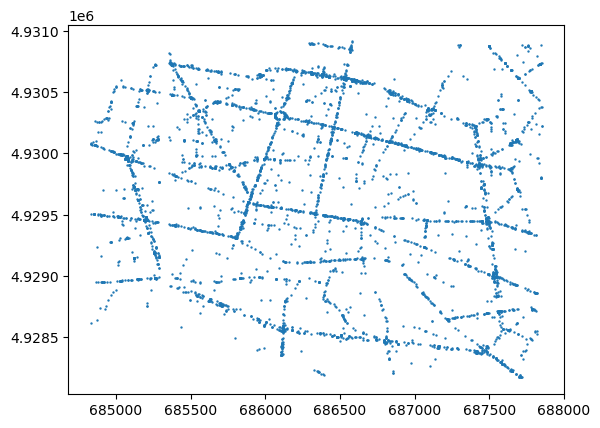

In [204]:
x=incidenti['X']
y=incidenti['Y']

plt.scatter(x,y,s=0.5)
plt.show()